=== NETFLIX RECOMMENDATION SYSTEM ANALYSIS ===

Creating sample Netflix-like dataset...
Loaded 47574 ratings for 1000 users and 500 movies
=== DATA EXPLORATION ===
Ratings shape: (47574, 3)
Movies shape: (500, 3)

Ratings distribution:
rating
1     2338
2     4726
3     9556
4    16592
5    14362
Name: count, dtype: int64


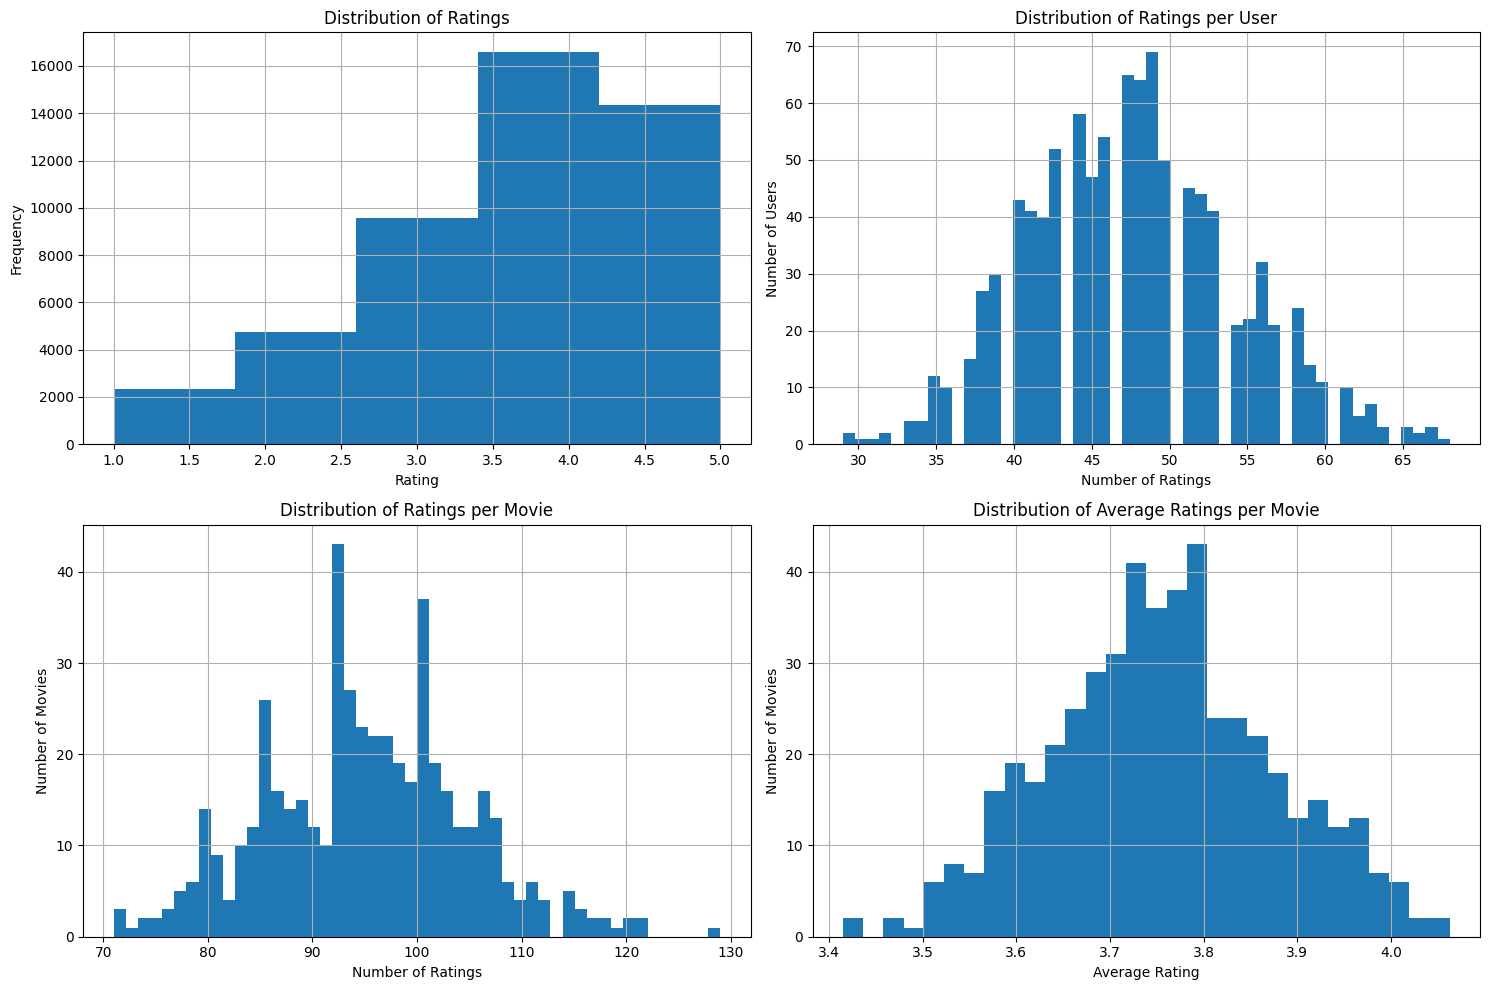


Data Sparsity: 0.9049 (90.49%)
User-Item Matrix Shape: (1000, 500)
Training set size: 38059
Testing set size: 9515

=== USER-BASED COLLABORATIVE FILTERING ===
User similarity matrix shape: (1000, 1000)

Evaluating User-Based CF...
User-Based CF Results:
RMSE: 1.3991
MAE: 1.1047

=== ITEM-BASED COLLABORATIVE FILTERING ===
Item similarity matrix shape: (500, 500)

Evaluating Item-Based CF...
Item-Based CF Results:
RMSE: 1.3704
MAE: 1.0794

=== MATRIX FACTORIZATION (SVD) ===
SVD decomposition completed with 50 factors

Evaluating SVD Matrix Factorization...
SVD Matrix Factorization Results:
RMSE: 2.9639
MAE: 2.7379

=== MODEL COMPARISON ===
           Model      RMSE       MAE
0  User-Based CF  1.399056  1.104721
1  Item-Based CF  1.370382  1.079371
2            SVD  2.963913  2.737892

Best Model: Item-Based CF (Lowest RMSE: 1.3704)

Top 5 recommendations for User 103:
1. Movie_106 (Thriller) - Predicted Rating: 5.00
2. Movie_220 (Thriller) - Predicted Rating: 5.00
3. Movie_362 (Sci-Fi)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings('ignore')

class NetflixRecommendationSystem:
    def __init__(self):
        self.ratings_df = None
        self.movies_df = None
        self.user_item_matrix = None
        self.train_data = None
        self.test_data = None
        self.user_similarity = None
        self.item_similarity = None
        
    def load_data(self, ratings_path=None, movies_path=None):
        """
        Load Netflix dataset or create sample data for demonstration
        """
        if ratings_path and movies_path:
            # Load actual Netflix data
            self.ratings_df = pd.read_csv(ratings_path)
            self.movies_df = pd.read_csv(movies_path)
        else:
            # Create sample data for demonstration
            print("Creating sample Netflix-like dataset...")
            np.random.seed(42)
            
            # Create sample users and movies
            n_users = 1000
            n_movies = 500
            n_ratings = 50000
            
            # Generate random ratings
            user_ids = np.random.randint(1, n_users+1, n_ratings)
            movie_ids = np.random.randint(1, n_movies+1, n_ratings)
            ratings = np.random.choice([1, 2, 3, 4, 5], n_ratings, 
                                     p=[0.05, 0.1, 0.2, 0.35, 0.3])
            
            self.ratings_df = pd.DataFrame({
                'user_id': user_ids,
                'movie_id': movie_ids,
                'rating': ratings
            })
            
            self.ratings_df = self.ratings_df.drop_duplicates(['user_id', 'movie_id'])
            
            movie_titles = [f"Movie_{i}" for i in range(1, n_movies+1)]
            genres = ['Action', 'Comedy', 'Drama', 'Horror', 'Romance', 'Sci-Fi', 'Thriller']
            
            self.movies_df = pd.DataFrame({
                'movie_id': range(1, n_movies+1),
                'title': movie_titles,
                'genre': np.random.choice(genres, n_movies)
            })
            
        print(f"Loaded {len(self.ratings_df)} ratings for {self.ratings_df['user_id'].nunique()} users and {self.ratings_df['movie_id'].nunique()} movies")
        
    def explore_data(self):
        """
        Perform exploratory data analysis
        """
        print("=== DATA EXPLORATION ===")
        print(f"Ratings shape: {self.ratings_df.shape}")
        print(f"Movies shape: {self.movies_df.shape}")
        print(f"\nRatings distribution:")
        print(self.ratings_df['rating'].value_counts().sort_index())
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        self.ratings_df['rating'].hist(bins=5, ax=axes[0,0])
        axes[0,0].set_title('Distribution of Ratings')
        axes[0,0].set_xlabel('Rating')
        axes[0,0].set_ylabel('Frequency')
        
        # Ratings per user
        user_rating_counts = self.ratings_df.groupby('user_id').size()
        user_rating_counts.hist(bins=50, ax=axes[0,1])
        axes[0,1].set_title('Distribution of Ratings per User')
        axes[0,1].set_xlabel('Number of Ratings')
        axes[0,1].set_ylabel('Number of Users')
        
        # Ratings per movie
        movie_rating_counts = self.ratings_df.groupby('movie_id').size()
        movie_rating_counts.hist(bins=50, ax=axes[1,0])
        axes[1,0].set_title('Distribution of Ratings per Movie')
        axes[1,0].set_xlabel('Number of Ratings')
        axes[1,0].set_ylabel('Number of Movies')
        
        # Average rating per movie
        avg_ratings = self.ratings_df.groupby('movie_id')['rating'].mean()
        avg_ratings.hist(bins=30, ax=axes[1,1])
        axes[1,1].set_title('Distribution of Average Ratings per Movie')
        axes[1,1].set_xlabel('Average Rating')
        axes[1,1].set_ylabel('Number of Movies')
        
        plt.tight_layout()
        plt.show()
        
        # Data sparsity analysis
        n_users = self.ratings_df['user_id'].nunique()
        n_movies = self.ratings_df['movie_id'].nunique()
        n_ratings = len(self.ratings_df)
        sparsity = 1 - (n_ratings / (n_users * n_movies))
        print(f"\nData Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
        
    def create_user_item_matrix(self):
        """
        Create user-item matrix for collaborative filtering
        """
        self.user_item_matrix = self.ratings_df.pivot_table(
            index='user_id', 
            columns='movie_id', 
            values='rating'
        ).fillna(0)
        
        print(f"User-Item Matrix Shape: {self.user_item_matrix.shape}")
        return self.user_item_matrix
    
    def train_test_split_data(self, test_size=0.2):
        """
        Split data into training and testing sets
        """
        self.train_data, self.test_data = train_test_split(
            self.ratings_df, test_size=test_size, random_state=42
        )
        
        print(f"Training set size: {len(self.train_data)}")
        print(f"Testing set size: {len(self.test_data)}")
        
    def user_based_collaborative_filtering(self, n_users=50):
        """
        Implement user-based collaborative filtering
        """
        print("\n=== USER-BASED COLLABORATIVE FILTERING ===")
        
        # Create training user-item matrix
        train_matrix = self.train_data.pivot_table(
            index='user_id', columns='movie_id', values='rating'
        ).fillna(0)
        
        # Calculate user similarity matrix
        user_similarity = cosine_similarity(train_matrix)
        self.user_similarity = pd.DataFrame(
            user_similarity, 
            index=train_matrix.index, 
            columns=train_matrix.index
        )
        
        print(f"User similarity matrix shape: {self.user_similarity.shape}")
        
        def predict_rating(user_id, movie_id):
            if user_id not in train_matrix.index or movie_id not in train_matrix.columns:
                return train_matrix.values.mean()
            
            # Find similar users who rated this movie
            similar_users = self.user_similarity[user_id].sort_values(ascending=False)[1:n_users+1]
            similar_users_ratings = []
            similarities = []
            
            for sim_user_id, similarity in similar_users.items():
                if train_matrix.loc[sim_user_id, movie_id] > 0:  # User rated this movie
                    similar_users_ratings.append(train_matrix.loc[sim_user_id, movie_id])
                    similarities.append(similarity)
            
            if not similar_users_ratings:
                return train_matrix.values.mean()
            
            # Weighted average of similar users' ratings
            numerator = sum(sim * rating for sim, rating in zip(similarities, similar_users_ratings))
            denominator = sum(abs(sim) for sim in similarities)
            
            return numerator / denominator if denominator > 0 else train_matrix.values.mean()
        
        return predict_rating
    
    def item_based_collaborative_filtering(self, n_items=50):
        """
        Implement item-based collaborative filtering
        """
        print("\n=== ITEM-BASED COLLABORATIVE FILTERING ===")
        
        # Create training user-item matrix
        train_matrix = self.train_data.pivot_table(
            index='user_id', columns='movie_id', values='rating'
        ).fillna(0)
        
        # Calculate item similarity matrix (transpose for item-item similarity)
        item_similarity = cosine_similarity(train_matrix.T)
        self.item_similarity = pd.DataFrame(
            item_similarity, 
            index=train_matrix.columns, 
            columns=train_matrix.columns
        )
        
        print(f"Item similarity matrix shape: {self.item_similarity.shape}")
        
        def predict_rating(user_id, movie_id):
            if user_id not in train_matrix.index or movie_id not in train_matrix.columns:
                return train_matrix.values.mean()
            
            # Find similar movies that this user has rated
            user_ratings = train_matrix.loc[user_id]
            rated_movies = user_ratings[user_ratings > 0].index
            
            if movie_id not in self.item_similarity.index:
                return train_matrix.values.mean()
            
            similar_movies = self.item_similarity[movie_id].sort_values(ascending=False)[1:n_items+1]
            similar_movies_ratings = []
            similarities = []
            
            for sim_movie_id, similarity in similar_movies.items():
                if sim_movie_id in rated_movies:
                    similar_movies_ratings.append(user_ratings[sim_movie_id])
                    similarities.append(similarity)
            
            if not similar_movies_ratings:
                return train_matrix.values.mean()
            
            # Weighted average of similar movies' ratings
            numerator = sum(sim * rating for sim, rating in zip(similarities, similar_movies_ratings))
            denominator = sum(abs(sim) for sim in similarities)
            
            return numerator / denominator if denominator > 0 else train_matrix.values.mean()
        
        return predict_rating
    
    def matrix_factorization_svd(self, n_factors=50):
        """
        Implement matrix factorization using SVD
        """
        print("\n=== MATRIX FACTORIZATION (SVD) ===")
        
        # Create training user-item matrix
        train_matrix = self.train_data.pivot_table(
            index='user_id', columns='movie_id', values='rating'
        ).fillna(0)
        
        # Perform SVD
        U, sigma, Vt = svds(train_matrix.values, k=n_factors)
        sigma = np.diag(sigma)
        
        # Reconstruct the matrix
        predicted_ratings = np.dot(np.dot(U, sigma), Vt)
        self.svd_predictions = pd.DataFrame(
            predicted_ratings, 
            index=train_matrix.index, 
            columns=train_matrix.columns
        )
        
        print(f"SVD decomposition completed with {n_factors} factors")
        
        def predict_rating(user_id, movie_id):
            if user_id not in self.svd_predictions.index or movie_id not in self.svd_predictions.columns:
                return train_matrix.values.mean()
            return self.svd_predictions.loc[user_id, movie_id]
        
        return predict_rating
    
    def evaluate_model(self, predict_function, model_name):
        """
        Evaluate recommendation model
        """
        predictions = []
        actuals = []
        
        print(f"\nEvaluating {model_name}...")
        
        for _, row in self.test_data.iterrows():
            user_id = row['user_id']
            movie_id = row['movie_id']
            actual_rating = row['rating']
            
            predicted_rating = predict_function(user_id, movie_id)
            
            # Clip predictions to valid rating range
            predicted_rating = np.clip(predicted_rating, 1, 5)
            
            predictions.append(predicted_rating)
            actuals.append(actual_rating)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        
        print(f"{model_name} Results:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return rmse, mae, predictions, actuals
    
    def get_user_recommendations(self, user_id, predict_function, n_recommendations=10):
        """
        Get top-N movie recommendations for a user
        """
        # Get movies not rated by the user
        user_ratings = self.ratings_df[self.ratings_df['user_id'] == user_id]
        rated_movies = set(user_ratings['movie_id'].values)
        all_movies = set(self.movies_df['movie_id'].values)
        unrated_movies = all_movies - rated_movies
        
        # Predict ratings for unrated movies
        movie_predictions = []
        for movie_id in unrated_movies:
            predicted_rating = predict_function(user_id, movie_id)
            movie_predictions.append((movie_id, predicted_rating))
        
        # Sort by predicted rating and get top N
        movie_predictions.sort(key=lambda x: x[1], reverse=True)
        top_recommendations = movie_predictions[:n_recommendations]
        
        # Get movie details
        recommended_movies = []
        for movie_id, predicted_rating in top_recommendations:
            movie_info = self.movies_df[self.movies_df['movie_id'] == movie_id]
            if not movie_info.empty:
                recommended_movies.append({
                    'movie_id': movie_id,
                    'title': movie_info.iloc[0]['title'],
                    'genre': movie_info.iloc[0]['genre'],
                    'predicted_rating': predicted_rating
                })
        
        return recommended_movies
    
    def get_similar_movies(self, movie_id, n_similar=10):
        """
        Get similar movies based on item-based collaborative filtering
        """
        if self.item_similarity is None:
            print("Item similarity matrix not computed. Run item-based collaborative filtering first.")
            return []
        
        if movie_id not in self.item_similarity.index:
            print(f"Movie ID {movie_id} not found in similarity matrix.")
            return []
        
        # Get similar movies
        similar_movies = self.item_similarity[movie_id].sort_values(ascending=False)[1:n_similar+1]
        
        # Get movie details
        similar_movie_list = []
        for sim_movie_id, similarity in similar_movies.items():
            movie_info = self.movies_df[self.movies_df['movie_id'] == sim_movie_id]
            if not movie_info.empty:
                similar_movie_list.append({
                    'movie_id': sim_movie_id,
                    'title': movie_info.iloc[0]['title'],
                    'genre': movie_info.iloc[0]['genre'],
                    'similarity': similarity
                })
        
        return similar_movie_list
    
    def run_complete_analysis(self):
        """
        Run the complete recommendation system analysis
        """
        print("=== NETFLIX RECOMMENDATION SYSTEM ANALYSIS ===\n")
        
        # Load and explore data
        self.load_data()
        self.explore_data()
        
        # Create user-item matrix
        self.create_user_item_matrix()
        
        # Split data
        self.train_test_split_data()
        
        models = {}
        
        user_based_predict = self.user_based_collaborative_filtering()
        rmse_ub, mae_ub, _, _ = self.evaluate_model(user_based_predict, "User-Based CF")
        models['User-Based CF'] = {'rmse': rmse_ub, 'mae': mae_ub, 'predict': user_based_predict}
        
        item_based_predict = self.item_based_collaborative_filtering()
        rmse_ib, mae_ib, _, _ = self.evaluate_model(item_based_predict, "Item-Based CF")
        models['Item-Based CF'] = {'rmse': rmse_ib, 'mae': mae_ib, 'predict': item_based_predict}
        
        svd_predict = self.matrix_factorization_svd()
        rmse_svd, mae_svd, _, _ = self.evaluate_model(svd_predict, "SVD Matrix Factorization")
        models['SVD'] = {'rmse': rmse_svd, 'mae': mae_svd, 'predict': svd_predict}
        
        print("\n=== MODEL COMPARISON ===")
        comparison_df = pd.DataFrame({
            'Model': list(models.keys()),
            'RMSE': [models[model]['rmse'] for model in models],
            'MAE': [models[model]['mae'] for model in models]
        })
        print(comparison_df)
        
        # Find best model
        best_model = min(models.keys(), key=lambda x: models[x]['rmse'])
        print(f"\nBest Model: {best_model} (Lowest RMSE: {models[best_model]['rmse']:.4f})")
        
        sample_user = self.ratings_df['user_id'].iloc[0]
        recommendations = self.get_user_recommendations(
            sample_user, models[best_model]['predict'], n_recommendations=5
        )
        
        print(f"\nTop 5 recommendations for User {sample_user}:")
        for i, movie in enumerate(recommendations, 1):
            print(f"{i}. {movie['title']} ({movie['genre']}) - Predicted Rating: {movie['predicted_rating']:.2f}")
        
        if 'Item-Based CF' in models:
            sample_movie = self.ratings_df['movie_id'].iloc[0]
            similar_movies = self.get_similar_movies(sample_movie, n_similar=5)
            
            movie_title = self.movies_df[self.movies_df['movie_id'] == sample_movie]['title'].iloc[0]
            print(f"\nMovies similar to '{movie_title}':")
            for i, movie in enumerate(similar_movies, 1):
                print(f"{i}. {movie['title']} ({movie['genre']}) - Similarity: {movie['similarity']:.3f}")
        
        return models

if __name__ == "__main__":
    recommender = NetflixRecommendationSystem()
    models = recommender.run_complete_analysis()
